# Module import

In [161]:
from netCDF4 import Dataset                             
import numpy as np                                      
from scipy import ndimage                               
import matplotlib.pyplot as plt           
import matplotlib.colors as mcolors              
from matplotlib.patches import Rectangle                
from scipy.ndimage import zoom
from skimage.transform import resize
import cartopy.crs as ccrs                              
import cartopy.feature as cfeature     
import cartopy.io.shapereader as shpreader
import sys
sys.path.insert(1, "/home/users/mendrika/SSA/SA/module")
import snflics
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta

# Choose nowcast origin and lead time (in hour)

In [162]:
year = "2024"
month = "02"
day = "28"
hour = "15"
minute = "00"

In [163]:
lead_time = 1

# Configurations

## Zambia extent

In [164]:
DISPLAY_LON_MIN = 21.167515
DISPLAY_LON_MAX = 35.316326
DISPLAY_LAT_MIN = -18.414806
DISPLAY_LAT_MAX = -7.9918404

# NetNCC Base Directory

In [165]:
NetCC_geodata = Dataset("/gws/ssde/j25b/swift/NetNCC_preds/coords_zambia_MSG.nc")
NetCC_lats = NetCC_geodata["lat"][:]
NetCC_lons = NetCC_geodata["lon"][:]

NetCC_CONTEXT_LAT_MIN = np.min(NetCC_lats)
NetCC_CONTEXT_LAT_MAX = np.max(NetCC_lats)
NetCC_CONTEXT_LON_MIN = np.min(NetCC_lons)
NetCC_CONTEXT_LON_MAX = np.max(NetCC_lons)

In [166]:
def load_NetCC_nowcast(year, month, day, hour, minute, lead_time):
    path_NetNCC = f'/gws/ssde/j25b/swift/NetNCC_preds/{year}/{month}'
    file = f"{path_NetNCC}/{year}{month}{day}{hour}{minute}_leadtime_{lead_time}hr.nc"
    return Dataset(file, mode='r')["core_prob"][:]

# NFLICS

In [167]:
def compute_NFLICS_latlon(ny, nx, top, bottom, left, right):
    """
    Generate latitude and longitude grids for NFLICS nowcasts.

    Parameters
    ----------
    ny, nx : int
        Array shape (rows, columns) of the nowcast grid.
    top, bottom, left, right : float
        Domain boundaries in degrees (EPSG:4326).
    Returns
    -------
    NFLICS_lats, NFLICS_lons : np.ndarray
        2D latitude and longitude grids of shape (ny, nx).
    """
    # Derive pixel size dynamically to avoid mismatch
    dx = (right - left) / nx
    dy = (top - bottom) / ny

    # 1D coordinate arrays (pixel centres)
    lons_1d = left + (np.arange(nx) + 0.5) * dx
    lats_1d = top  - (np.arange(ny) + 0.5) * dy

    # 2D grids
    NFLICS_lons, NFLICS_lats = np.meshgrid(lons_1d, lats_1d)

    return NFLICS_lats, NFLICS_lons


# SADC domain
top, bottom, left, right = 0.043560, -38.0, 8.0, 55.026801
ny, nx = 1217, 1307

NFLICS_lats, NFLICS_lons = compute_NFLICS_latlon(ny, nx, top, bottom, left, right)

NFLICS_LON_MIN = np.min(NFLICS_lons)
NFLICS_LON_MAX = np.max(NFLICS_lons)
NFLICS_LAT_MIN = np.min(NFLICS_lats)
NFLICS_LAT_MAX = np.max(NFLICS_lats)

print(NFLICS_lats.shape, NFLICS_lons.shape)
print(f"Latitude range:  {NFLICS_LAT_MIN:.4f} → {NFLICS_LAT_MAX:.4f}")
print(f"Longitude range: {NFLICS_LON_MIN:.4f} → {NFLICS_LON_MAX:.4f}")

(1217, 1307) (1217, 1307)
Latitude range:  -37.9844 → 0.0279
Longitude range: 8.0180 → 55.0088


In [168]:
def load_NFLICS_nowcast(year, month, day, hour, minute, lead_time):
    NFLICS_BaseDir = f"/gws/ssde/j25b/swift/nflics_nowcasts/{year}/{month}/{day}/{hour}{minute}"
    file = f"{NFLICS_BaseDir}/Nowcast_{year}{month}{day}{hour}{minute}_000_sadc.nc"
    data = Dataset(file, mode='r')["Probability"][lead_time, :, :]
    return data

# Ground truth 

In [169]:
def update_hour(date_dict, hours_to_add, minutes_to_add):
    """
    Add hours and minutes to a datetime dictionary and return the updated dict and a generated file path.

    Args:
        date_dict     (dict): Keys: 'year', 'month', 'day', 'hour', 'minute' as strings, e.g. "01", "23"
        hours_to_add   (int): Number of hours to add.
        minutes_to_add (int): Number of minutes to add.

    Returns:
        tuple:
            - dict: Updated datetime dictionary with all fields as zero-padded strings.
            - str: File path in the format YYYY/MM/YYYYMMDDHHMM.nc
    """
    # Parse the original time
    time_obj = datetime(
        int(date_dict["year"]),
        int(date_dict["month"]),
        int(date_dict["day"]),
        int(date_dict["hour"]),
        int(date_dict["minute"])
    )

    # Add hours
    updated = time_obj + timedelta(hours=hours_to_add, minutes=minutes_to_add)

    # Format updated dictionary
    new_date_dict = {
        "year":   f"{updated.year:04d}",
        "month":  f"{updated.month:02d}",
        "day":    f"{updated.day:02d}",
        "hour":   f"{updated.hour:02d}",
        "minute": f"{updated.minute:02d}"
    }

    # Generate file path
    file_path = f"{new_date_dict['year']}/{new_date_dict['month']}/{new_date_dict['year']}{new_date_dict['month']}{new_date_dict['day']}{new_date_dict['hour']}{new_date_dict['minute']}.nc"

    return {'time': new_date_dict, 'path': file_path}

In [170]:
def load_wavelet_dataset(year, month, day, hour, minute, lead_time):
    
    nowcast_origin = {
        "year":   year,
        "month":  month,
        "day":    day,
        "hour":   hour,
        "minute": minute,
    }

    nowcast_lt = update_hour(nowcast_origin, hours_to_add=lead_time, minutes_to_add=0)["time"]

    path_core = f"/gws/nopw/j04/cocoon/SSA_domain/ch9_wavelet/{nowcast_lt['year']}/{nowcast_lt['month']}"
    file = f"{path_core}/{nowcast_lt['year']}{nowcast_lt['month']}{nowcast_lt['day']}{nowcast_lt['hour']}{nowcast_lt['minute']}.nc"
    return Dataset(file, mode='r')["cores"]

# ZCAST

In [171]:
y_min, y_max = 580, 930
x_min, x_max = 1480, 1850

In [172]:
geodata = np.load("/gws/nopw/j04/cocoon/SSA_domain/lat_lon_2268_2080.npz")
Zambia_lons = geodata["lon"][y_min:y_max, x_min:x_max]
Zambia_lats = geodata["lat"][y_min:y_max, x_min:x_max]

# Load all nowcasts and ground truth

In [173]:
netncc = load_NetCC_nowcast(year, month, day, hour, minute, lead_time)

In [174]:
nflics = load_NFLICS_nowcast(year, month, day, hour, minute, lead_time)

In [175]:
ground_truth = load_wavelet_dataset(year, month, day, hour, minute, lead_time)[0, y_min:y_max, x_min:x_max] != 0

In [176]:
CONTEXT_LAT_MIN = np.min(Zambia_lats)
CONTEXT_LAT_MAX = np.max(Zambia_lats)
CONTEXT_LON_MIN = np.min(Zambia_lons)
CONTEXT_LON_MAX = np.max(Zambia_lons)

In [177]:
locations = {
    "Lusaka": [-15.3875, 28.3228],
    "Ndola": [-12.9683, 28.6366],
    "Kasama": [-10.2129, 31.1808],
    "Chinsali": [-10.5500, 32.0667],
    "Kabwe": [-14.4469, 28.4464],
    "Livingstone": [-17.8419, 25.8542],
    "Mongu": [-15.2484, 23.1274],
    "Mansa": [-11.1996, 28.8943],
    "Solwezi": [-12.1722, 26.3981],
    "Chipata": [-13.6339, 32.6508]
}

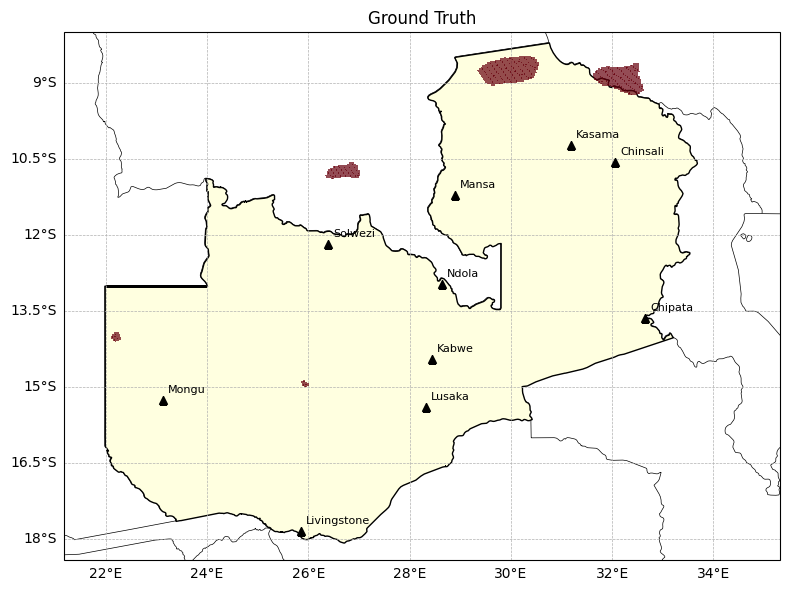

In [178]:
# Create figure and axis
fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set tight extent around Zambia
ax.set_extent([CONTEXT_LON_MIN, CONTEXT_LON_MAX, CONTEXT_LAT_MIN, CONTEXT_LAT_MAX], crs=ccrs.PlateCarree())

# Base features
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=0)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5, zorder=1)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5, zorder=1)

# Load Natural Earth country boundaries and extract Zambia only
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='10m',
                                        category='cultural', name=shapename)

for country in shpreader.Reader(countries_shp).records():
    if country.attributes['NAME'] == 'Zambia':
        ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                          facecolor='lightyellow', edgecolor='black', linewidth=1.0, zorder=2)

# Plot locations
for name, (lat, lon) in locations.items():
    ax.plot(lon, lat, marker="^", color="black", markersize=6, transform=ccrs.PlateCarree(), zorder=3)
    ax.text(lon + 0.1, lat + 0.1, name, fontsize=8, transform=ccrs.PlateCarree(), ha='left', va='bottom', color='black', zorder=4)

# Gridlines
gl = ax.gridlines(draw_labels=True, alpha=1, linestyle='--', linewidth=0.5)
gl.top_labels = False
gl.right_labels = False

# --- Plot the binary storm core mask ---
# Ensure output_data is binary (0 or 1)
# e.g., output_data = (cores != 0).astype(int)

# Mask zeros to make them transparent
masked_output = np.ma.masked_where(ground_truth == 0, ground_truth)

# Plot only the "blobs" (value == 1)
contour_core = ax.pcolormesh(
    Zambia_lons, Zambia_lats, masked_output,
    transform=ccrs.PlateCarree(),
    cmap=plt.cm.Reds,
    vmin=0, vmax=1,
    alpha=0.7,  # adjust opacity as you like
    zorder=2
)

plt.title("Ground Truth", fontsize=12)
plt.tight_layout()
plt.show()

# NetNCC

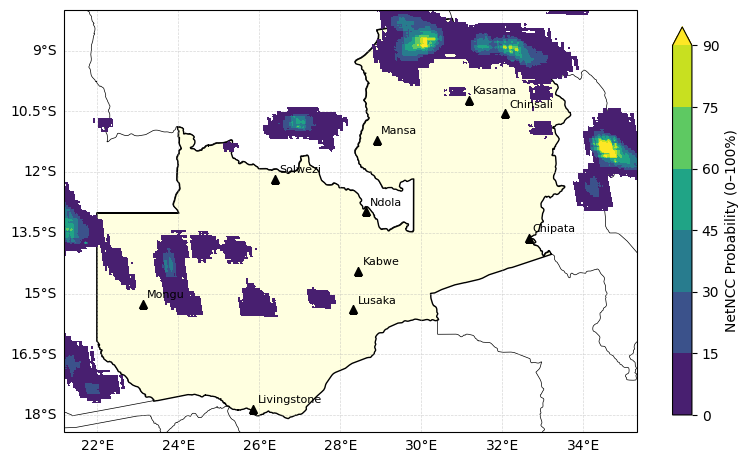

In [179]:
# Create figure and axis
fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set tight extent around Zambia
# ax.set_extent(
#     [NetCC_CONTEXT_LON_MIN, NetCC_CONTEXT_LON_MAX,
#      NetCC_CONTEXT_LAT_MIN, NetCC_CONTEXT_LAT_MAX],
#     crs=ccrs.PlateCarree()
# )

ax.set_extent([DISPLAY_LON_MIN, DISPLAY_LON_MAX, DISPLAY_LAT_MIN, DISPLAY_LAT_MAX], crs=ccrs.PlateCarree())

# Base features
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=0)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5, zorder=1)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5, zorder=1)

# Load Natural Earth country boundaries and extract Zambia only
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='10m',
                                        category='cultural', name=shapename)

for country in shpreader.Reader(countries_shp).records():
    if country.attributes['NAME'] == 'Zambia':
        ax.add_geometries(
            [country.geometry],
            crs=ccrs.PlateCarree(),
            facecolor='lightyellow',
            edgecolor='black',
            linewidth=1.0,
            zorder=2
        )
# Plot locations
for name, (lat, lon) in locations.items():
    ax.plot(lon, lat, marker="^", color="black", markersize=6,
            transform=ccrs.PlateCarree(), zorder=3)
    ax.text(lon + 0.1, lat + 0.1, name, fontsize=8,
            transform=ccrs.PlateCarree(), ha='left', va='bottom',
            color='black', zorder=4)

# Gridlines
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False

# Mask zero values (so they become transparent)
nowcast_masked = np.ma.masked_where(netncc <= 0, netncc)

# Plot nowcast only where > 0
contour_core = ax.contourf(
    NetCC_lons,
    NetCC_lats,
    nowcast_masked,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    extend="max",
    zorder=2
)

cbar = plt.colorbar(contour_core, ax=ax, orientation="vertical", shrink=0.4, pad=0.05)
cbar.set_label("NetNCC Probability (0–100%)", fontsize=10)

plt.tight_layout()
plt.show()


# NFLICS

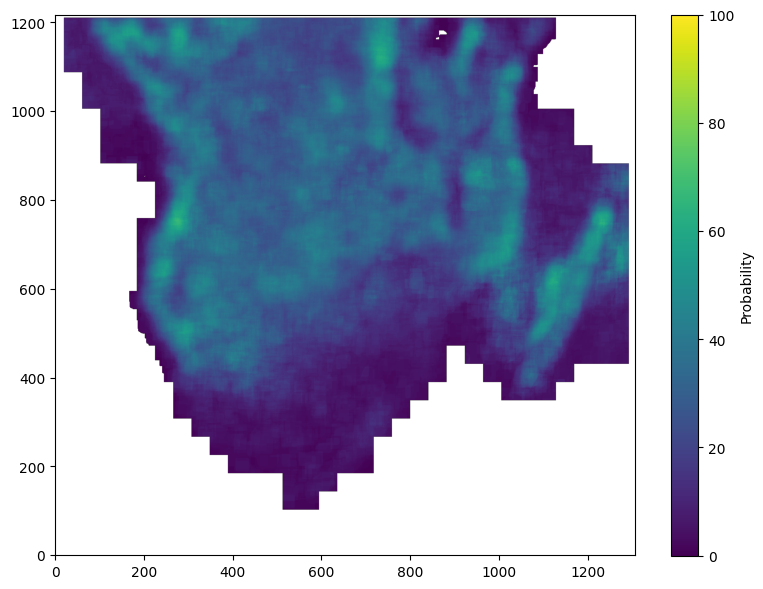

In [180]:
nflics_masked = np.ma.masked_where(nflics <= 0, nflics)

# Plot
plt.figure(figsize=(8, 6))
nflics_plot = plt.imshow(
    nflics_masked,
    origin="lower",
    cmap="viridis",
    vmin=0, vmax=100  # if it’s a probability field
)
plt.colorbar(nflics_plot, label="Probability")
plt.tight_layout()
plt.show()

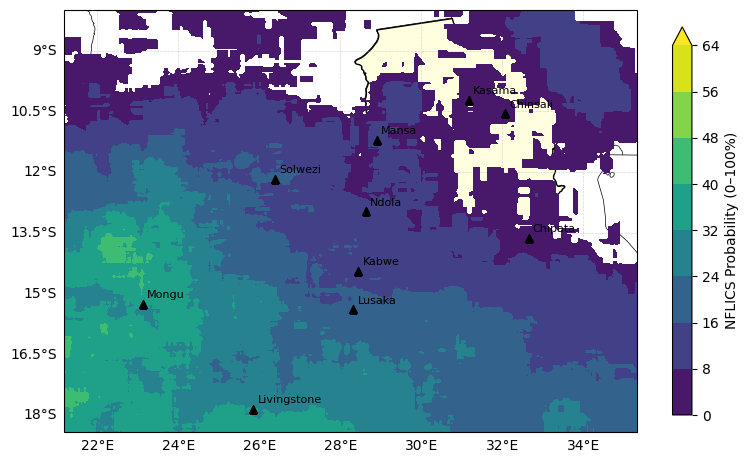

In [181]:
# --- Plot NFLICS nowcast probability field (same style as NetCC) ---

# Create figure and axis
fig = plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set tight extent around Zambia
ax.set_extent(
    [DISPLAY_LON_MIN, DISPLAY_LON_MAX,
     DISPLAY_LAT_MIN, DISPLAY_LAT_MAX],
    crs=ccrs.PlateCarree()
)

# Base features
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=0)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5, zorder=1)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5, zorder=1)

# Load Natural Earth country boundaries and extract Zambia only
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(
    resolution='10m',
    category='cultural',
    name=shapename
)

for country in shpreader.Reader(countries_shp).records():
    if country.attributes['NAME'] == 'Zambia':
        ax.add_geometries(
            [country.geometry],
            crs=ccrs.PlateCarree(),
            facecolor='lightyellow',
            edgecolor='black',
            linewidth=1.0,
            zorder=2
        )

# Plot locations
for name, (lat, lon) in locations.items():
    ax.plot(lon, lat, marker="^", color="black", markersize=6,
            transform=ccrs.PlateCarree(), zorder=3)
    ax.text(lon + 0.1, lat + 0.1, name, fontsize=8,
            transform=ccrs.PlateCarree(), ha='left', va='bottom',
            color='black', zorder=4)

# Gridlines
gl = ax.gridlines(draw_labels=True, alpha=0.5, linestyle='--', linewidth=0.5)
gl.right_labels = False
gl.top_labels = False

# Mask zero/low values (so they become transparent)
NFLICS_masked = np.ma.masked_where(nflics <= 5, nflics)

# Plot NFLICS nowcast field only where > 10
contour_core = ax.contourf(
    NFLICS_lons,
    NFLICS_lats,
    NFLICS_masked,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    extend="max",
    zorder=2
)

# --- Add colourbar ---
cbar = plt.colorbar(contour_core, ax=ax, orientation="vertical", shrink=0.4, pad=0.05)
cbar.set_label("NFLICS Probability (0–100%)", fontsize=10)

plt.tight_layout()
plt.show()


# All products

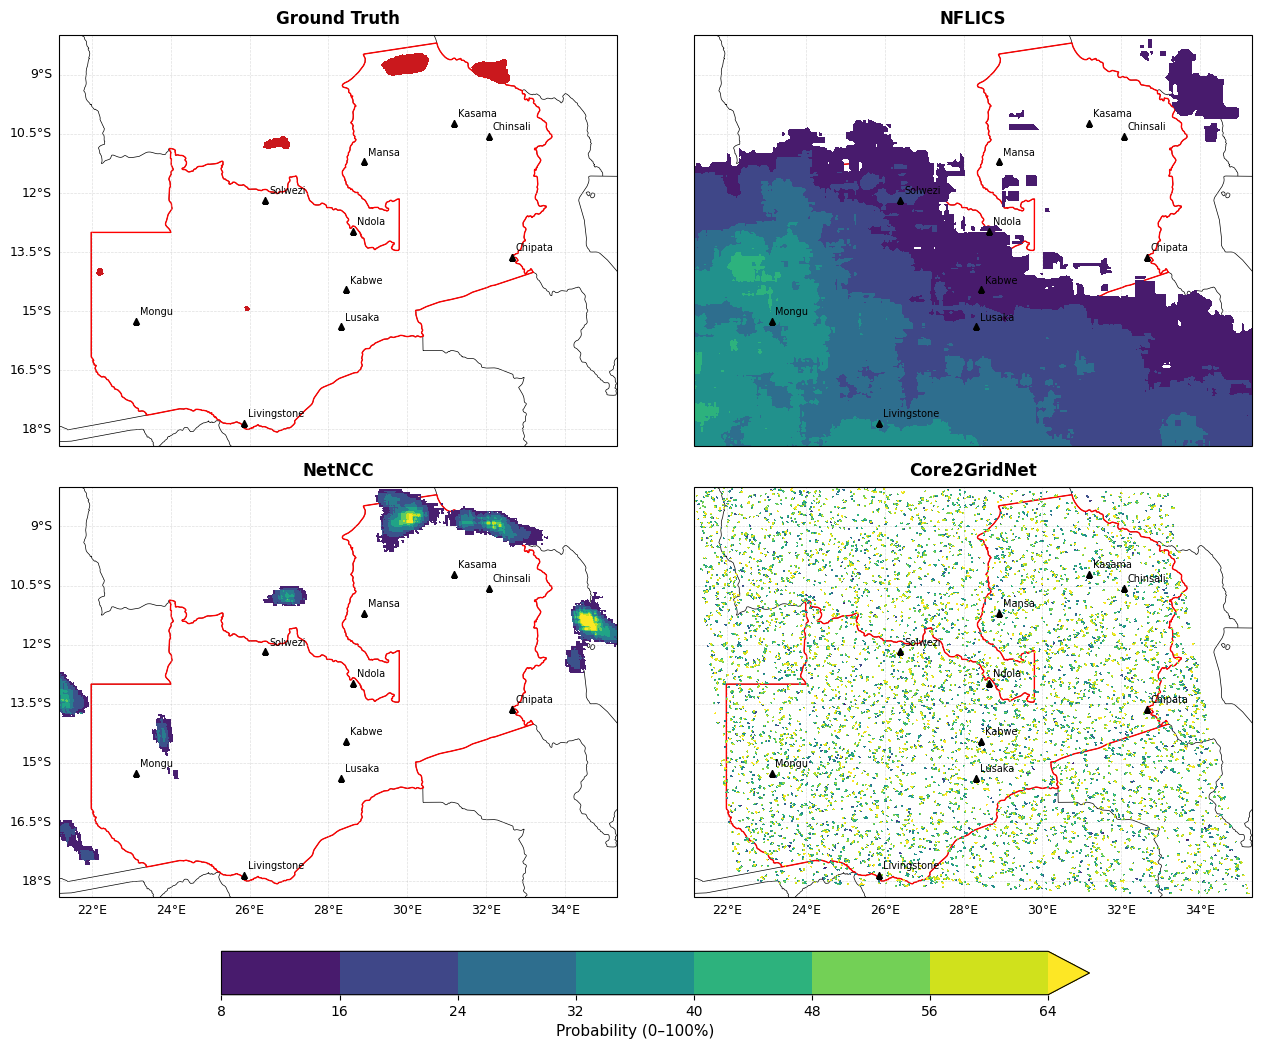

In [183]:
# --- Four-panel comparison: Ground Truth, NFLICS, NetNCC, Core2GridNet ---

fig, axes = plt.subplots(
    2, 2, figsize=(16, 14),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

plt.subplots_adjust(wspace=0.05, hspace=0.1)

# Common plotting setup
def setup_ax(ax, title, show_left=False, show_bottom=False):
    ax.set_extent([DISPLAY_LON_MIN, DISPLAY_LON_MAX, DISPLAY_LAT_MIN, DISPLAY_LAT_MAX],
                  crs=ccrs.PlateCarree())
    ax.set_title(title, fontsize=12, weight="bold", pad=8)
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', zorder=0)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=0)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5, zorder=1)
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5, zorder=1)

    # Zambia outline
    shapename = 'admin_0_countries'
    countries_shp = shpreader.natural_earth(resolution='10m',
                                            category='cultural', name=shapename)
    for country in shpreader.Reader(countries_shp).records():
        if country.attributes['NAME'] == 'Zambia':
            ax.add_geometries(
                [country.geometry], crs=ccrs.PlateCarree(),
                facecolor='none', edgecolor='red', linewidth=1.0, zorder=2
            )

    # City markers
    for name, (lat, lon) in locations.items():
        ax.plot(lon, lat, marker="^", color="black", markersize=5,
                transform=ccrs.PlateCarree(), zorder=3)
        ax.text(lon + 0.1, lat + 0.1, name, fontsize=7,
                transform=ccrs.PlateCarree(), ha='left', va='bottom',
                color='black', zorder=4)

    # Gridlines with labels
    gl = ax.gridlines(draw_labels=True, alpha=0.4, linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = show_left
    gl.bottom_labels = show_bottom
    gl.xlabel_style = {'size': 9}
    gl.ylabel_style = {'size': 9}
    return ax


# --- Row 1: Ground Truth (left) and NFLICS (right) ---
ax_gt = setup_ax(axes[0, 0], "Ground Truth", show_left=True, show_bottom=False)
gt_masked = np.ma.masked_where(ground_truth <= 0, ground_truth)
im1 = ax_gt.contourf(Zambia_lons, Zambia_lats, gt_masked,
                     transform=ccrs.PlateCarree(),
                     cmap="Reds", vmin=0, vmax=1, zorder=2)

ax_nf = setup_ax(axes[0, 1], "NFLICS", show_left=False, show_bottom=False)
NFLICS_masked = np.ma.masked_where(nflics <= 10, nflics)
im2 = ax_nf.contourf(NFLICS_lons, NFLICS_lats, NFLICS_masked,
                     transform=ccrs.PlateCarree(),
                     cmap="viridis", extend="max", zorder=2)

# --- Row 2: NetNCC (left) and Core2GridNet (right) ---
ax_nc = setup_ax(axes[1, 0], "NetNCC", show_left=True, show_bottom=True)
NetCC_masked = np.ma.masked_where(nowcast <= 5, nowcast)
im3 = ax_nc.contourf(NetCC_lons, NetCC_lats, NetCC_masked,
                     transform=ccrs.PlateCarree(),
                     cmap="viridis", extend="max", zorder=2)

ax_cg = setup_ax(axes[1, 1], "Core2GridNet", show_left=False, show_bottom=True)
core2grid = np.random.uniform(0, 100, size=(350, 370)).astype(np.float32)
C2G_masked = np.ma.masked_where(core2grid <= 70, core2grid)
im4 = ax_cg.contourf(Zambia_lons, Zambia_lats, C2G_masked,
                     transform=ccrs.PlateCarree(),
                     cmap="viridis", extend="max", zorder=2)

# --- Shared colourbar across all panels ---
cbar = fig.colorbar(im2, ax=axes.ravel().tolist(),
                    orientation="horizontal", shrink=0.7, pad=0.05)
cbar.set_label("Probability (0–100%)", fontsize=11)

plt.show()
